<참고문헌>

- https://today-1.tistory.com/60

# Drive mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 현재 파일의 경로 입력
%cd '/content/drive/MyDrive/Colab Notebooks/TAEMTAEM class/final'

/content/drive/MyDrive/Colab Notebooks/TAEMTAEM class/final


In [3]:
!ls

data_tr_city.csv  model.pth	      NLinear_train.ipynb
data_ts_city.csv  NLinear_test.ipynb


# Import

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Data download

In [5]:
from google.colab import files

#files.upload()
#files.upload()

In [6]:
!ls

data_tr_city.csv  model.pth	      NLinear_train.ipynb
data_ts_city.csv  NLinear_test.ipynb


# Data preprocessing

In [7]:
train_df_raw = pd.read_csv('data_tr_city.csv')
test_df_raw = pd.read_csv('data_ts_city.csv')

datetime               0
구미 혁신도시배수지 유출유량 적산차    8
dtype: int64 datetime               0
구미 혁신도시배수지 유출유량 적산차    0
dtype: int64


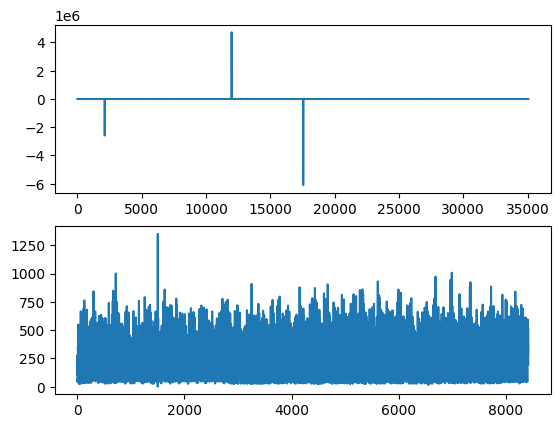

In [8]:
print(train_df_raw.isna().sum(), test_df_raw.isna().sum())
plt.subplot(2,1,1).plot(train_df_raw.iloc[:,1])
plt.subplot(2,1,2).plot(test_df_raw.iloc[:,1])

datetime               8
구미 혁신도시배수지 유출유량 적산차    0
dtype: int64 datetime               0
구미 혁신도시배수지 유출유량 적산차    0
dtype: int64


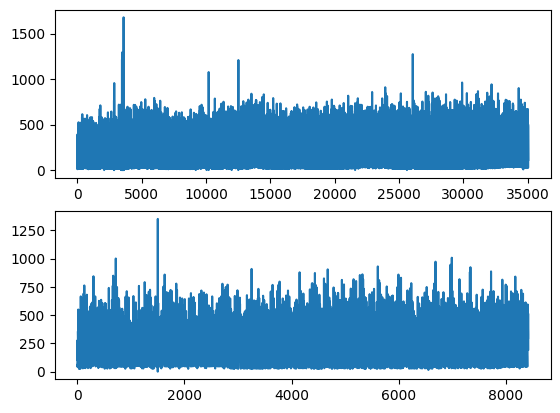

In [9]:
train_df = train_df_raw.copy()
#train_df = train_df_raw.copy()[8759:]
train_df[train_df.iloc[:,1]>2000] = None
train_df[train_df.iloc[:,1]<0] = None
train_df = train_df.interpolate()
# test data는 결측치, 이상치가 없음
test_df = test_df_raw.copy()
test_df[test_df.iloc[:,1]>2000] = None
test_df[test_df.iloc[:,1]<0] = None
test_df = test_df.interpolate()
print(train_df.isna().sum(), test_df.isna().sum())
plt.subplot(2,1,1).plot(train_df.iloc[:,1])
plt.subplot(2,1,2).plot(test_df.iloc[:,1])

In [10]:
#train_data = np.array(train_df['구미 혁신도시배수지 유출유량 적산차'].tolist()).reshape(-1,1)
#test_data = np.array(test_df['구미 혁신도시배수지 유출유량 적산차'].tolist()).reshape(-1,1)
train_data = np.array(train_df.iloc[:,1].tolist()).reshape(-1,1)
test_data = np.array(test_df.iloc[:,1].tolist()).reshape(-1,1)

In [11]:
def time_slide_df(data, window_size, forcast_size):
    X = []
    Y = []

    for i in range(len(data)-window_size-forcast_size):
        feature = data[i:i+window_size]
        target = data[i+window_size:i+window_size+forcast_size]
        X.append(feature)
        Y.append(target)

    return torch.tensor(X).float(), torch.tensor(Y).float()

# NLinear model

In [12]:
class LTSF_NLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_NLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    def forward(self, x):
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x

In [58]:
### Univariable ###
### 데이터 셋 생성 ###
#window_size = 144
#window_size = 216
#window_size = 360
#window_size = 480
window_size = 336 # !
#window_size = 388
#window_size = 412
forcast_size= 24
batch_size = 256
#batch_size = 512

train_x, train_y = time_slide_df(train_data, window_size, forcast_size)
test_x, test_y = time_slide_df(test_data, window_size, forcast_size)

train_dl = DataLoader(data.TensorDataset(train_x, train_y), batch_size = batch_size, shuffle=True)
test_dl = DataLoader(data.TensorDataset(test_x, test_y),  batch_size = test_x.shape[0], shuffle=False)


### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 50
lr = 0.001
NLinear_model = LTSF_NLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(NLinear_model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(NLinear_model.parameters(), lr=lr, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0) # 추가
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    NLinear_model.train()
    for batch_idx, (feature, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = NLinear_model(feature)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    scheduler.step() # 추가 
    train_loss_list.append(np.mean(loss_list))

    NLinear_model.eval()
    with torch.no_grad():
        for feature, target in test_dl:
            output = NLinear_model(feature)
            test_loss = criterion(output, target)
            test_loss_list.append(test_loss)

#    if valid_loss < max_loss:
#        torch.save(DLinear_model, 'DLinear_model.pth')
#        max_loss = valid_loss
#        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
#        dlinear_best_epoch = epoch
#        dlinear_best_train_loss = np.mean(loss_list)
#        dlinear_best_valid_loss = np.mean(valid_loss.item())
#        dlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), test_loss))

  2%|▏         | 1/50 [00:00<00:14,  3.32it/s]

epoch = 1, train_loss : 107.620, test_loss : 96.131


  4%|▍         | 2/50 [00:00<00:22,  2.15it/s]

epoch = 2, train_loss : 94.637, test_loss : 90.997


  6%|▌         | 3/50 [00:01<00:18,  2.48it/s]

epoch = 3, train_loss : 91.812, test_loss : 89.799


  8%|▊         | 4/50 [00:01<00:17,  2.65it/s]

epoch = 4, train_loss : 90.918, test_loss : 89.015


 10%|█         | 5/50 [00:02<00:20,  2.22it/s]

epoch = 5, train_loss : 90.598, test_loss : 89.266


 12%|█▏        | 6/50 [00:02<00:18,  2.43it/s]

epoch = 6, train_loss : 90.305, test_loss : 88.638


 14%|█▍        | 7/50 [00:03<00:19,  2.18it/s]

epoch = 7, train_loss : 90.271, test_loss : 88.890


 16%|█▌        | 8/50 [00:03<00:17,  2.42it/s]

epoch = 8, train_loss : 90.143, test_loss : 88.757


 18%|█▊        | 9/50 [00:03<00:18,  2.24it/s]

epoch = 9, train_loss : 90.163, test_loss : 88.631


 20%|██        | 10/50 [00:04<00:15,  2.53it/s]

epoch = 10, train_loss : 90.101, test_loss : 88.973


 22%|██▏       | 11/50 [00:04<00:14,  2.76it/s]

epoch = 11, train_loss : 90.134, test_loss : 88.822


 24%|██▍       | 12/50 [00:04<00:16,  2.37it/s]

epoch = 12, train_loss : 90.037, test_loss : 88.905


 26%|██▌       | 13/50 [00:05<00:14,  2.52it/s]

epoch = 13, train_loss : 90.024, test_loss : 88.466


 28%|██▊       | 14/50 [00:05<00:16,  2.12it/s]

epoch = 14, train_loss : 90.013, test_loss : 88.684


 30%|███       | 15/50 [00:06<00:17,  2.05it/s]

epoch = 15, train_loss : 89.922, test_loss : 88.650


 32%|███▏      | 16/50 [00:07<00:18,  1.87it/s]

epoch = 16, train_loss : 89.960, test_loss : 88.585


 34%|███▍      | 17/50 [00:07<00:17,  1.93it/s]

epoch = 17, train_loss : 89.912, test_loss : 88.614


 36%|███▌      | 18/50 [00:08<00:16,  1.93it/s]

epoch = 18, train_loss : 89.879, test_loss : 88.720


 38%|███▊      | 19/50 [00:08<00:16,  1.86it/s]

epoch = 19, train_loss : 89.832, test_loss : 88.314


 40%|████      | 20/50 [00:09<00:14,  2.13it/s]

epoch = 20, train_loss : 89.840, test_loss : 88.348


 42%|████▏     | 21/50 [00:09<00:12,  2.37it/s]

epoch = 21, train_loss : 89.749, test_loss : 88.412


 44%|████▍     | 22/50 [00:09<00:13,  2.15it/s]

epoch = 22, train_loss : 89.724, test_loss : 88.308


 46%|████▌     | 23/50 [00:10<00:11,  2.41it/s]

epoch = 23, train_loss : 89.718, test_loss : 88.292


 48%|████▊     | 24/50 [00:10<00:10,  2.58it/s]

epoch = 24, train_loss : 89.679, test_loss : 88.315


 50%|█████     | 25/50 [00:11<00:11,  2.27it/s]

epoch = 25, train_loss : 89.585, test_loss : 88.273


 52%|█████▏    | 26/50 [00:11<00:09,  2.48it/s]

epoch = 26, train_loss : 89.576, test_loss : 88.364


 54%|█████▍    | 27/50 [00:11<00:10,  2.20it/s]

epoch = 27, train_loss : 89.571, test_loss : 88.273


 56%|█████▌    | 28/50 [00:12<00:09,  2.41it/s]

epoch = 28, train_loss : 89.532, test_loss : 88.166


 58%|█████▊    | 29/50 [00:12<00:09,  2.25it/s]

epoch = 29, train_loss : 89.474, test_loss : 88.270


 60%|██████    | 30/50 [00:13<00:08,  2.50it/s]

epoch = 30, train_loss : 89.446, test_loss : 88.133


 62%|██████▏   | 31/50 [00:13<00:07,  2.39it/s]

epoch = 31, train_loss : 89.409, test_loss : 88.087


 64%|██████▍   | 32/50 [00:13<00:06,  2.62it/s]

epoch = 32, train_loss : 89.381, test_loss : 88.114


 66%|██████▌   | 33/50 [00:14<00:06,  2.80it/s]

epoch = 33, train_loss : 89.334, test_loss : 88.018


 68%|██████▊   | 34/50 [00:14<00:06,  2.61it/s]

epoch = 34, train_loss : 89.316, test_loss : 87.988


 70%|███████   | 35/50 [00:14<00:05,  2.81it/s]

epoch = 35, train_loss : 89.285, test_loss : 88.029


 72%|███████▏  | 36/50 [00:15<00:05,  2.63it/s]

epoch = 36, train_loss : 89.257, test_loss : 88.039


 74%|███████▍  | 37/50 [00:15<00:04,  2.82it/s]

epoch = 37, train_loss : 89.236, test_loss : 87.900


 76%|███████▌  | 38/50 [00:15<00:04,  2.85it/s]

epoch = 38, train_loss : 89.200, test_loss : 87.911


 78%|███████▊  | 39/50 [00:16<00:04,  2.39it/s]

epoch = 39, train_loss : 89.179, test_loss : 87.933


 80%|████████  | 40/50 [00:16<00:03,  2.58it/s]

epoch = 40, train_loss : 89.138, test_loss : 87.928


 82%|████████▏ | 41/50 [00:17<00:03,  2.77it/s]

epoch = 41, train_loss : 89.116, test_loss : 87.877


 84%|████████▍ | 42/50 [00:17<00:03,  2.56it/s]

epoch = 42, train_loss : 89.096, test_loss : 87.856


 86%|████████▌ | 43/50 [00:17<00:02,  2.67it/s]

epoch = 43, train_loss : 89.080, test_loss : 87.817


 88%|████████▊ | 44/50 [00:18<00:02,  2.18it/s]

epoch = 44, train_loss : 89.059, test_loss : 87.818


 90%|█████████ | 45/50 [00:19<00:02,  2.09it/s]

epoch = 45, train_loss : 89.031, test_loss : 87.823


 92%|█████████▏| 46/50 [00:19<00:02,  1.72it/s]

epoch = 46, train_loss : 89.016, test_loss : 87.812


 94%|█████████▍| 47/50 [00:20<00:01,  1.83it/s]

epoch = 47, train_loss : 89.016, test_loss : 87.813


 96%|█████████▌| 48/50 [00:20<00:01,  1.89it/s]

epoch = 48, train_loss : 89.007, test_loss : 87.797


 98%|█████████▊| 49/50 [00:21<00:00,  1.81it/s]

epoch = 49, train_loss : 89.001, test_loss : 87.797


100%|██████████| 50/50 [00:21<00:00,  2.29it/s]

epoch = 50, train_loss : 88.994, test_loss : 87.795


# NLinear plot

In [37]:
predict = NLinear_model(test_x)

In [38]:
criterion = torch.nn.L1Loss()
loss = criterion(predict, test_y)
loss

tensor(87.8731, grad_fn=<MeanBackward0>)

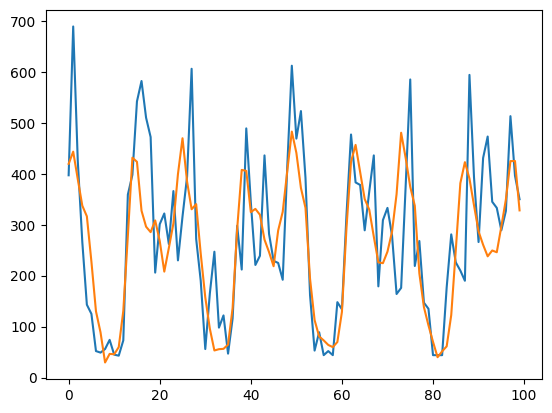

In [39]:
plt.plot(test_y.detach().numpy().squeeze(-1)[-100:,-1])
plt.plot(predict.detach().numpy().squeeze(-1)[-100:,-1])

# Model save

In [50]:
#----------------------------------------
#
# <현재성능>
#
# epoch = 50, train_loss : 88.991, test_loss : 87.789
#
#----------------------------------------
#torch.save(NLinear_model, 'model.pth')

In [51]:
!ls

data_tr_city.csv  model.pth	      NLinear_train.ipynb
data_ts_city.csv  NLinear_test.ipynb


In [52]:
model = torch.load('model.pth')

In [53]:
predict = model(test_x)

In [54]:
criterion = torch.nn.L1Loss()
loss = criterion(predict, test_y)
loss

tensor(87.7894, grad_fn=<MeanBackward0>)

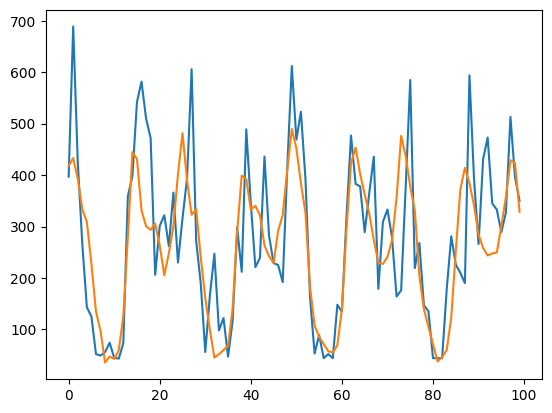

In [55]:
plt.plot(test_y.detach().numpy().squeeze(-1)[-100:,-1])
plt.plot(predict.detach().numpy().squeeze(-1)[-100:,-1])